In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy.stats as st

def plot_1d_regression(
    x_star,
    gpm,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    gpm      --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    m_star, v_star = gpm.predict(x_star)

    f_lower = (
        m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    f_upper = (
        m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
   
    ax.fill_between(
        x_star.flatten(),
        f_lower.flatten(),
        f_upper.flatten(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.'
    )
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = gpm.posterior_samples_f(
            x_star,
            num_samples
        )
        ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
        ax.plot([], [], 'r', lw=0.5, label="Posterior samples")

    ax.plot(gpm.X,
            gpm.Y,
            'kx',
            markersize=5,
            markeredgewidth=2,
            label='Observations'
    )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best')
    
    return m_star, v_star


def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    
    The evaluation of the informationa acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    sigma = np.sqrt(v)
    af_values = alpha(m, sigma, Y.max(), **alpha_params)
    next_id = np.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel(
        'Maximum Upper Interval',
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        np.linspace(0, af_max, 100),
        color=sns.color_palette()[1],
        linewidth=1
    )
    
def maximize(
    f,
    gpr,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowldege.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        
        # Evaluate information acquisition function
        af_values = alpha(
            m,
            sigma,
            gpr.Y.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        af_all.append(af_values[i])

        # Make observation
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        # Update GPR
        gpr.set_XY(X, y)
        if optimize:
            gpr.optimize()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                gpr,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all

# Probability of Improvement

## Objectives

+ Develop intuition about the probability of improvement

## Probability of Improvement
Let's reintroduce the same running example as the previous hands-on activity.

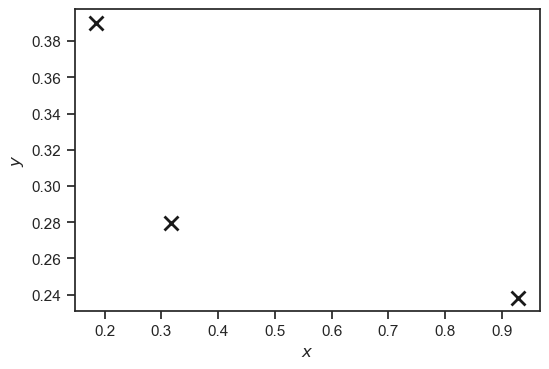

In [2]:
def f(x):
    """A function to optimize."""
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:

$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$

where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

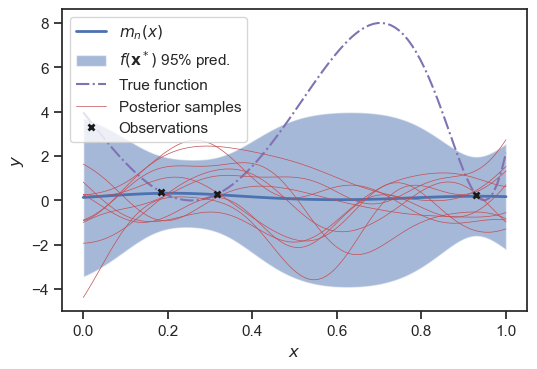

In [3]:
import GPy

k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
x_star = np.linspace(0, 1, 100)[:, None]
plot_1d_regression(x_star, gpr, f_true=f);

What if you try to find the point that maximizes the probability of getting an observation greater than the ones you have so far?
Let's derive this.
First, let's call $y_n^*$ the current maximum in your dataset, i.e.,

$$
y_n^* = \max_{1\le i\le n}y_i.
$$

We define the following acquisition function:

$$
a_n(\mathbf{x}) = \mathbb{P}[y > y_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$

We read "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:

$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[y > y_n^* + \psi | x, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{y - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& 1 - \mathbb{P}\left[\frac{y - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \le \frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& 1 - \Phi\left(\frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \right)\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - y_n^* - \psi}{\sigma_n(\mathbf{x})} \right),
\end{align}
$$

where we used that since $y_n | \mathbf{x}_n, \mathcal{D}_n$ is Gaussian with mean $\mu_n(\mathbf{x})$ and variance $\sigma_n^2(\mathbf{x})$, then $\frac{y_n-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}$ is a standard normal, and we also used that the CDF of the standard normal satisfies this property:

$$
\Phi(-z) = 1 - \Phi(z).
$$

Here is the code for this activation function:

In [4]:
def poi(m, sigma, ymax, psi=0.):
    """Return the probability of improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    psi   -- A parameter that controls exploration.
    """
    return st.norm.cdf((m - ymax - psi) / sigma)

Let's visualize this:

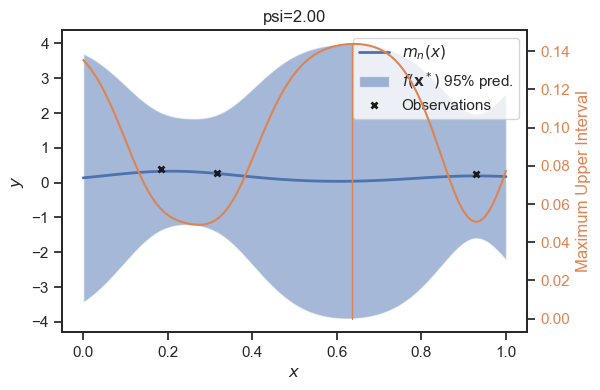

In [5]:
plot_iaf(
    x_star,
    gpr,
    poi,
    alpha_params=dict(psi=2.0)
)

### Questions
+ Experiment with different values of $\psi$. --> done
+ When do you get exploration? --> when psi is larger
+ When do you get exploitation? --> when psi is smaller

## Bayesian global optimization with the probability of improvement

Let's now run the Bayesian global optimization algorithm using the probability of improvement as the information acquisition function.
I have already included the generic function `maximize()` from the previous section.
Here is how to use it:

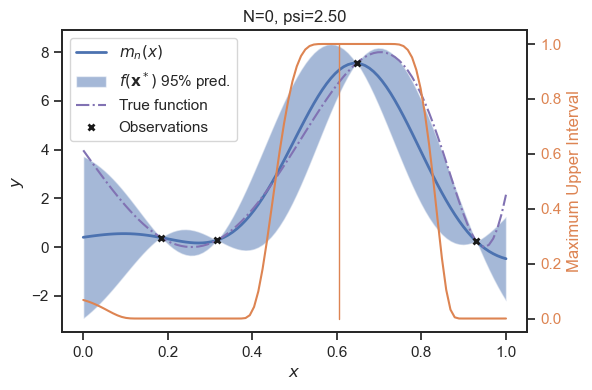

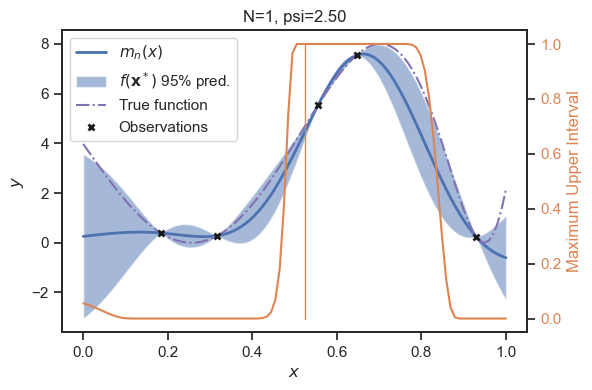

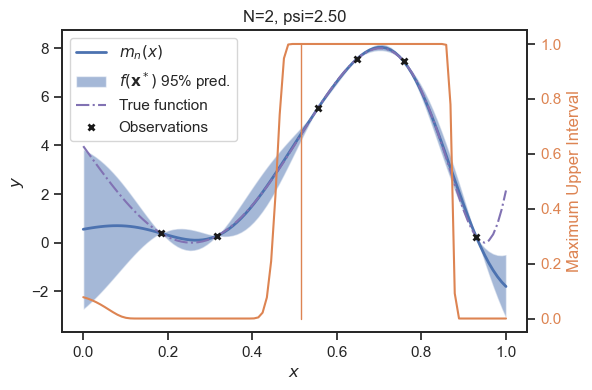

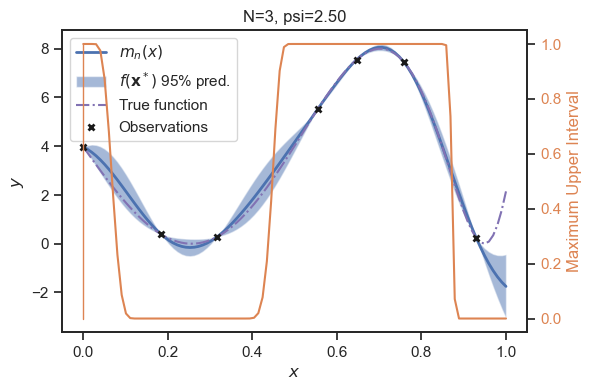

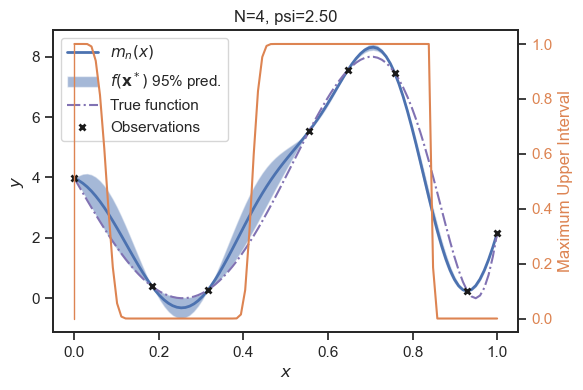

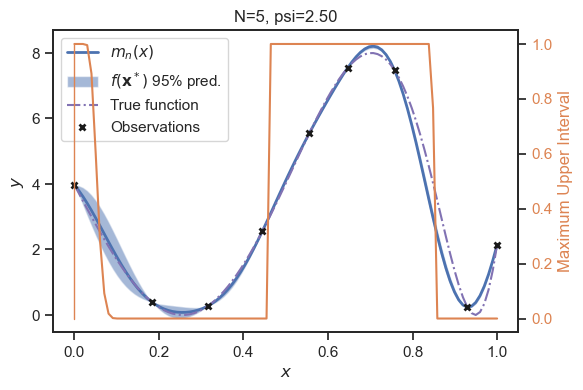

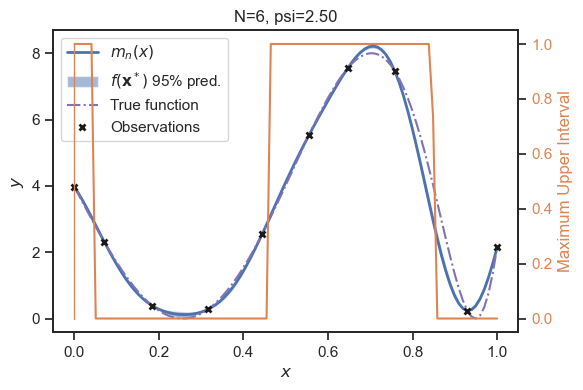

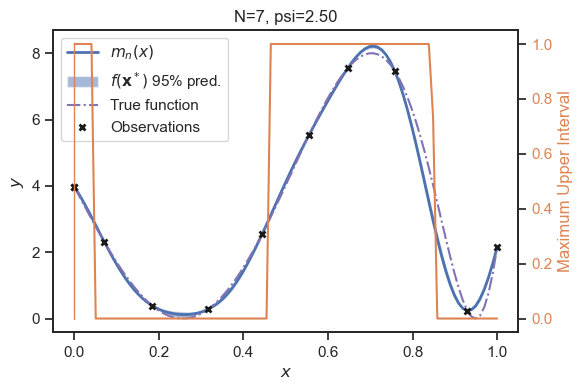

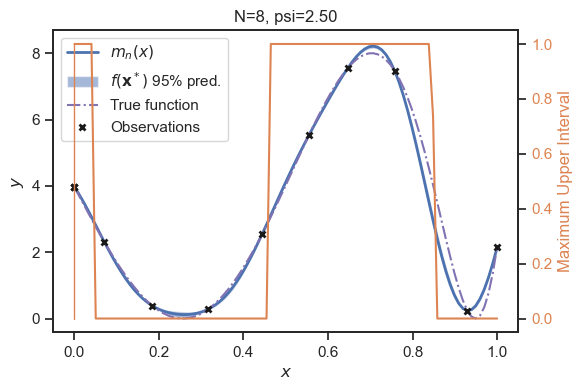

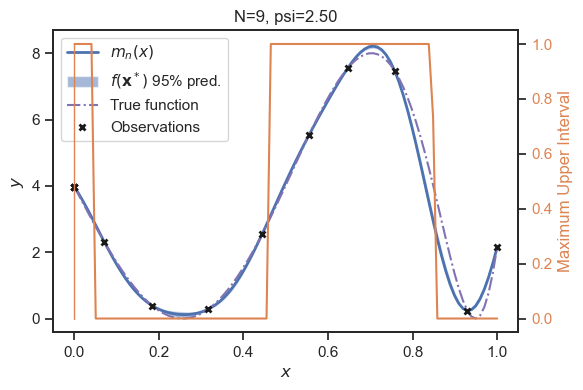

In [6]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(
    f,
    gpr,
    x_star,
    poi,
    alpha_params=dict(psi=2.5),
    max_it=10,
    plot=1
)

### Questions

+ Repeat the main algorithm using POI for a $\psi$ that exploits. Does the method converge? --> no
+ Repeat the main algorithm using POI for a $\psi$ that explores. Does the method converge? --> no